In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import seaborn as sns
from collections import defaultdict
import random
import matplotlib as mpl

# Section 1. Model

In [37]:
def normalized_graph(graph):
    for i in graph.nodes():
        sum_v=np.sum([graph[i][j]['weight'] for j in graph.nodes() if (i,j) in graph.edges()])
        for j in graph.nodes():
            if (i,j) in graph.edges():
                if sum_v==0:
                    graph[i][j]['prob']=0
                else:
                    graph[i][j]['prob']=graph[i][j]['weight']/sum_v
    return graph

def dynamical_burden_model(graph,t_list,node_capacity_dict,node_burden_dict):
    #graph=normalized_graph(graph)

    interval=1
    
    output_mat=[]

    for i in graph.nodes():
        graph.nodes[i]['C']=0
        graph.nodes[i]['new_C']=0
        
    for t in t_list:
        tot_burden=np.sum([node_burden_dict[i][t] for i in graph.nodes()])
        
        for i in graph.nodes():
            graph.nodes[i]['capacity']=-node_capacity_dict[i] ###left capacity
            graph.nodes[i]['burden']=node_burden_dict[i][t] ##excessive burden
            
            in_flow_burden=0
            for j in graph.nodes():
                if (j,i) in graph.edges(): 
                    in_flow_burden+=graph[j][i]['weight']*tot_burden
                    
            
            ###absorb
            if in_flow_burden+graph.nodes[i]['capacity']<0:
                    graph.nodes[i]['absorb']=1
            else:
                if graph.nodes[i]['capacity']<0:
                    graph.nodes[i]['absorb']=-graph.nodes[i]['capacity']/in_flow_burden
                else:
                    graph.nodes[i]['absorb']=0
               
     
        for i in graph.nodes():
            decrease_bruden=0
            for j in graph.nodes():
                if (i,j) in graph.edges(): 
                    decrease_bruden-=tot_burden*graph[i][j]['weight']*graph.nodes[j]['absorb'] ###of no network

            graph.nodes[i]['burden']=graph.nodes[i]['burden']+decrease_bruden
                
            output_mat.append([t,i,graph.nodes[i]['burden'],decrease_bruden])
            

    return output_mat
            

In [11]:
def compute_adsorptive_capacity(df_output,df_output_be_compared):
    return 1-df_output['C'].sum()/df_output_be_compared['C'].sum()

# Section 2. Diagaram 

In [25]:
def example_external_burden(t_list,node_burden,typex):
    fig,ax=plt.subplots(1,1,figsize=(2.5,2))
    ax.plot(t_list,node_burden,color='#F78181',alpha=1,linewidth=4,label='Burden increase')
    #ax.set_ylim(0,1)

    ax.set_xlabel('t')
    ax.set_ylabel('Excessive stress')
    plt.tight_layout()
    fig.savefig('result/diagram/example_burden_'+typex+'.png',dpi=600)
    

def example_temporal_capacity_plot(df_output,df_output_be_compared,label):
    
    fig,ax=plt.subplots(1,1,figsize=(2.5,2))
    df_temp=df_output.groupby(['t'])['burden'].mean().reset_index()
    

    ax.plot(df_temp['t'],df_temp['burden'],color='#377eb8',linewidth=4,alpha=0.6)
    
    df_temp2=df_output_be_compared.groupby(['t'])['burden'].mean().reset_index()
    ax.plot(df_temp2['t'],df_temp2['burden'],color='#999999',linewidth=4,alpha=0.6)
    
    ax.fill_between(df_temp2['t'],df_temp2['burden'],df_temp['burden'],color='#377eb8',alpha=0.1)
    
    r=compute_adsorptive_capacity(df_output,df_output_be_compared)
    
    print('adsorptive_capacity',round(r,2))
    #ax.set_ylim(-1.2,1)
    #ax.set_ylim(-6,1)
    ax.invert_yaxis()
    #ax.axhline(y=0, color='black', linestyle=':',linewidth=2)
    ax.set_xlabel('t')
    ax.set_ylabel('Average node stress')
    plt.tight_layout()
    fig.savefig('result/diagram/exampl_node_burden_('+label+').png',dpi=600)
    
def compute_adsorptive_capacity(df_output,df_output_be_compared):
    
    return 1-df_output['burden'].sum()/df_output_be_compared['burden'].sum()

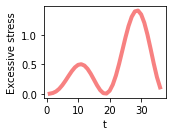

In [9]:
t_list=np.arange(36)+1
t_list_true=t_list/1
node_burden_wave=(np.sin((t_list_true/3)-1.5)+1)*0.1*t_list*0.25
#node_burden_wave=[1]*len(t_list)
example_external_burden(t_list_true,node_burden_wave,'waves')


adsorptive_capacity 0.4
adsorptive_capacity 0.55
adsorptive_capacity 0.48
adsorptive_capacity 0.7


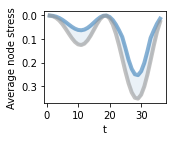

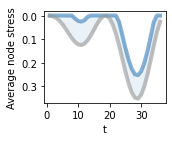

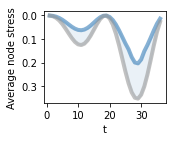

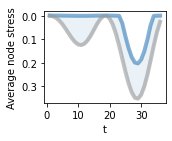

In [38]:
######Example case

node_burden_zero=[0]*len(t_list)

example_graph_1=nx.DiGraph()
example_graph_1.add_edge('a','b',weight=0.25)
example_graph_1.add_edge('a','c',weight=0.25)
example_graph_1.add_edge('a','d',weight=0)

example_graph_2=nx.DiGraph()
example_graph_2.add_edge('a','b',weight=0.5)
example_graph_2.add_edge('a','c',weight=0.5)
example_graph_2.add_edge('a','d',weight=0)

example_graph_3=nx.DiGraph()
example_graph_3.add_edge('a','b',weight=0.167)
example_graph_3.add_edge('a','c',weight=0.167)
example_graph_3.add_edge('a','d',weight=0.167)

example_graph_4=nx.DiGraph()
example_graph_4.add_edge('a','b',weight=0.33)
example_graph_4.add_edge('a','c',weight=0.33)
example_graph_4.add_edge('a','d',weight=0.33)

example_graph_0=nx.DiGraph()
example_graph_0.add_edge('a','b',weight=0)
example_graph_0.add_edge('a','c',weight=0)
example_graph_0.add_edge('a','d',weight=0)


#node_capacity_dict=dict(zip(['a','b','c','d'],[0,0.8,0.8,0.8,0.8]))
#node_capacity_dict=dict(zip(['a','b','c','d'],[0,0.25,0.25,0.25,0.1]))
node_capacity_dict=dict(zip(['a','b','c','d'],[0,0.2,0.2,0.2,0.2]))



output_change_burden=[]

for node_select, burden_label in zip([['a']],['_single']):
    
    node_burden_dict = defaultdict(dict)
    for node in example_graph_0.nodes():
        if node in node_select:
            node_burden_dict[node]=dict(zip(t_list,node_burden_wave))
        else:
            node_burden_dict[node]=dict(zip(t_list,node_burden_zero))
    
    output_mat=dynamical_burden_model(example_graph_0,t_list,node_capacity_dict,node_burden_dict)

    df_output_be_compared=pd.DataFrame(np.mat(output_mat),columns=['t','node','burden','decrease_bruden'])
    df_output_be_compared['decrease_bruden']=df_output_be_compared['decrease_bruden'].astype(float)
    
    
    df_output_be_compared['t']=df_output_be_compared['t'].astype(float)
    df_output_be_compared['burden']=df_output_be_compared['burden'].astype(float)

    
    for graph, g_label in zip([example_graph_1,example_graph_2,example_graph_3,example_graph_4],['graph_1','graph_2','graph_3','graph_4']):
        
        output_mat=dynamical_stress_model(graph,t_list,node_capacity_dict,node_burden_dict)

        df_output=pd.DataFrame(np.mat(output_mat),columns=['t','node','burden','decrease_bruden'])
        
        df_output['t']=df_output['t'].astype(float)
        df_output['burden']=df_output['burden'].astype(float)
        example_temporal_capacity_plot(df_output,df_output_be_compared,g_label+burden_label)
        
        output_change_burden.append([g_label,burden_label,df_output['burden'].sum()])
#print(output_mat)
    
df_change_burden=pd.DataFrame(np.mat(output_change_burden),columns=['g_label','burden_label','change_of_burden'])